<h1> Applied Data Science Coursera Capstone </h1>

The purpose of this notebook is to accomplish the Applied Data Science Coursera Capstone requirements

In [1]:
#!jt -t oceans16 -fs 12 -ofs 12
import pandas as pd
import numpy as np
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


Business Understanding - A description of the problem and a discussion of the background. 

Predict accident severity taking into account:
<ul>
    <li> Weather Conditions </li>
    <li> Road Conditions </li>
</ul>

Data Understanding - A description of the data and how it will be used to solve the problem. 

Attributes to use:
<ul>
    <li> Location </li>
    <li> Road Condition </li>
    <li> Weather Condition </li>
    <li> Junction Type </li>
    <li> Car Speeding </li>
    <li> Number of People Involved </li>
    <li> Light Conditions </li>
    <li> Number of Vehicles involved </li>
</ul>

In [2]:
df = pd.read_csv("../Data-Collisions.csv")
df.columns

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [3]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [4]:
colData = df[['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'COLLISIONTYPE',
               'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',  'WEATHER', 'ROADCOND', 'LIGHTCOND', 
               'SPEEDING', 'UNDERINFL', 'INATTENTIONIND']]
#Location, Road Condition, Weather Condition, Junction Type, Car Speeding, Number of People Involved, Light Conditions, Number of Vehicles involved

In [5]:
colData.head()

,SEVERITYCODE,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,UNDERINFL,INATTENTIONIND
0,2,-122.323148,47.703140,Intersection,Angles,2,2,At Intersection (intersection related),Overcast,Wet,Daylight,NaN,N,NaN
1,1,-122.347294,47.647172,Block,Sideswipe,2,2,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,NaN,0,NaN
2,1,-122.334540,47.607871,Block,Parked Car,4,3,Mid-Block (not related to intersection),Overcast,Dry,Daylight,NaN,0,NaN
3,1,-122.334803,47.604803,Block,Other,3,3,Mid-Block (not related to intersection),Clear,Dry,Daylight,NaN,N,NaN
4,2,-122.306426,47.545739,Intersection,Angles,2,2,At Intersection (intersection related),Raining,Wet,Daylight,NaN,0,NaN


In [6]:
print("--------- Severity Code ---------")
print(colData['SEVERITYCODE'].value_counts())
print("--------- Address Type ---------")
print(colData['ADDRTYPE'].value_counts())
print("--------- Collision Type ---------")
print(colData['COLLISIONTYPE'].value_counts())
print("--------- Junction Type ---------")
print(colData['JUNCTIONTYPE'].value_counts())
print("--------- Weather ---------")
print(colData['WEATHER'].value_counts())
print("--------- Road Conditions ---------")
print(colData['ROADCOND'].value_counts())
print("--------- Light Conditions ---------")
print(colData['LIGHTCOND'].value_counts())
print("--------- Speeding ---------")
print(colData['SPEEDING'].value_counts())
print("--------- Under Influence ---------")
print(colData['UNDERINFL'].value_counts())
print("--------- Inattention ---------")
print(colData['INATTENTIONIND'].value_counts())


--------- Severity Code ---------
1    136485
2     58188
Name: SEVERITYCODE, dtype: int64
--------- Address Type ---------
Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64
--------- Collision Type ---------
Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64
--------- Junction Type ---------
Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64
--------- Weather ---------
C

In [7]:
colData.isna().sum()

SEVERITYCODE           0
X                   5334
Y                   5334
ADDRTYPE            1926
COLLISIONTYPE       4904
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE        6329
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
SPEEDING          185340
UNDERINFL           4884
INATTENTIONIND    164868
dtype: int64

In [8]:
colData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   ADDRTYPE        192747 non-null  object 
 4   COLLISIONTYPE   189769 non-null  object 
 5   PERSONCOUNT     194673 non-null  int64  
 6   VEHCOUNT        194673 non-null  int64  
 7   JUNCTIONTYPE    188344 non-null  object 
 8   WEATHER         189592 non-null  object 
 9   ROADCOND        189661 non-null  object 
 10  LIGHTCOND       189503 non-null  object 
 11  SPEEDING        9333 non-null    object 
 12  UNDERINFL       189789 non-null  object 
 13  INATTENTIONIND  29805 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 20.8+ MB


In [9]:
filterCond = (colData.LIGHTCOND == 'Other') | (colData.LIGHTCOND == 'Unknown') | \
                      (colData.LIGHTCOND == 'Dark - Unknown Lighting') |\
                      (colData.ROADCOND == 'Other') | (colData.ROADCOND == 'Unknown') | \
                      (colData.WEATHER == 'Other') | (colData.WEATHER == 'Unknown') | \
                      (colData.JUNCTIONTYPE == 'Other') | (colData.JUNCTIONTYPE == 'Unknown') | \
                      (colData.COLLISIONTYPE == 'Other')
colData = colData.drop(colData[filterCond].index)

In [10]:
colData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152645 entries, 0 to 194672
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    152645 non-null  int64  
 1   X               150036 non-null  float64
 2   Y               150036 non-null  float64
 3   ADDRTYPE        151959 non-null  object 
 4   COLLISIONTYPE   147747 non-null  object 
 5   PERSONCOUNT     152645 non-null  int64  
 6   VEHCOUNT        152645 non-null  int64  
 7   JUNCTIONTYPE    150502 non-null  object 
 8   WEATHER         147636 non-null  object 
 9   ROADCOND        147668 non-null  object 
 10  LIGHTCOND       147564 non-null  object 
 11  SPEEDING        5442 non-null    object 
 12  UNDERINFL       147763 non-null  object 
 13  INATTENTIONIND  25894 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 17.5+ MB


In [11]:
colData["LIGHTCOND"] = colData["LIGHTCOND"].replace("Dark - Street Lights Off", "Dark - No Street Lights")
colData["UNDERINFL"] = colData["UNDERINFL"].replace("N", 0)
colData["UNDERINFL"] = colData["UNDERINFL"].replace("0", 0)
colData["UNDERINFL"] = colData["UNDERINFL"].replace("1", 1)
colData["UNDERINFL"] = colData["UNDERINFL"].replace("Y", 1)
colData["INATTENTIONIND"] = colData["INATTENTIONIND"].replace("Y", 1)
colData["SPEEDING"] = colData["SPEEDING"].replace("Y", 1)

In [45]:

def list_count(columns, df):
    for col in columns:
        print(col)
        print(df[col].value_counts())
        print()

data_columns = ['SEVERITYCODE','ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 
 'ROADCOND','LIGHTCOND', 'SPEEDING', 'UNDERINFL', 'INATTENTIONIND']
list_count(data_columns, colData)


SEVERITYCODE
1    94818
2    48923
Name: SEVERITYCODE, dtype: int64

ADDRTYPE
Block           86381
Intersection    57360
Name: ADDRTYPE, dtype: int64

COLLISIONTYPE
Angles        33576
Parked Car    32260
Rear Ended    31534
Sideswipe     17020
Left Turn     13269
Pedestrian     6224
Cycles         5162
Right Turn     2774
Head On        1922
Name: COLLISIONTYPE, dtype: int64

JUNCTIONTYPE
Mid-Block (not related to intersection)              62014
At Intersection (intersection related)               55795
Mid-Block (but intersection related)                 17953
Driveway Junction                                     6327
At Intersection (but not related to intersection)     1542
Ramp Junction                                          110
Name: JUNCTIONTYPE, dtype: int64

WEATHER
Clear                       93350
Raining                     26670
Overcast                    22543
Snowing                       622
Fog/Smog/Smoke                419
Sleet/Hail/Freezing Rain       79
Blowin

Treat the following columns as true only if the field is filled.

In [13]:
colData['UNDERINFL'] = colData['UNDERINFL'].fillna(0)
colData['INATTENTIONIND'] = colData['INATTENTIONIND'].fillna(0)
colData['SPEEDING'] = colData['SPEEDING'].fillna(0)
colData.isna().sum()

SEVERITYCODE         0
X                 2609
Y                 2609
ADDRTYPE           686
COLLISIONTYPE     4898
PERSONCOUNT          0
VEHCOUNT             0
JUNCTIONTYPE      2143
WEATHER           5009
ROADCOND          4977
LIGHTCOND         5081
SPEEDING             0
UNDERINFL            0
INATTENTIONIND       0
dtype: int64

In [14]:
colData.dropna(inplace=True)
colData.isna().sum()

SEVERITYCODE      0
X                 0
Y                 0
ADDRTYPE          0
COLLISIONTYPE     0
PERSONCOUNT       0
VEHCOUNT          0
JUNCTIONTYPE      0
WEATHER           0
ROADCOND          0
LIGHTCOND         0
SPEEDING          0
UNDERINFL         0
INATTENTIONIND    0
dtype: int64

In [15]:
colData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143741 entries, 0 to 194672
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    143741 non-null  int64  
 1   X               143741 non-null  float64
 2   Y               143741 non-null  float64
 3   ADDRTYPE        143741 non-null  object 
 4   COLLISIONTYPE   143741 non-null  object 
 5   PERSONCOUNT     143741 non-null  int64  
 6   VEHCOUNT        143741 non-null  int64  
 7   JUNCTIONTYPE    143741 non-null  object 
 8   WEATHER         143741 non-null  object 
 9   ROADCOND        143741 non-null  object 
 10  LIGHTCOND       143741 non-null  object 
 11  SPEEDING        143741 non-null  float64
 12  UNDERINFL       143741 non-null  float64
 13  INATTENTIONIND  143741 non-null  float64
dtypes: float64(5), int64(3), object(6)
memory usage: 16.4+ MB


In [34]:
import seaborn as sns
#sns.boxplot(x="ADDRTYPE", y="SEVERITYCODE", data=colData)
severeCols = colData[colData.SEVERITYCODE == 2]
print(severeCols["ADDRTYPE"].value_counts())
notSevereCols = colData[colData.SEVERITYCODE == 1]
print(notSevereCols["ADDRTYPE"].value_counts())

Intersection    25747
Block           23176
Name: ADDRTYPE, dtype: int64
Block           63205
Intersection    31613
Name: ADDRTYPE, dtype: int64


Not severe collitions are most probable in blocks than intersections

In [46]:
list_count(data_columns, severeCols)

SEVERITYCODE
2    48923
Name: SEVERITYCODE, dtype: int64

ADDRTYPE
Intersection    25747
Block           23176
Name: ADDRTYPE, dtype: int64

COLLISIONTYPE
Rear Ended    13774
Angles        13338
Pedestrian     5599
Left Turn      5307
Cycles         4559
Parked Car     2564
Sideswipe      2350
Head On         843
Right Turn      589
Name: COLLISIONTYPE, dtype: int64

JUNCTIONTYPE
At Intersection (intersection related)               25205
Mid-Block (not related to intersection)              14795
Mid-Block (but intersection related)                  6285
Driveway Junction                                     2069
At Intersection (but not related to intersection)      533
Ramp Junction                                           36
Name: JUNCTIONTYPE, dtype: int64

WEATHER
Clear                       31585
Raining                      9499
Overcast                     7545
Fog/Smog/Smoke                138
Snowing                       118
Sleet/Hail/Freezing Rain       22
Blowing Sand/Dirt

In [47]:
list_count(data_columns, notSevereCols)

SEVERITYCODE
1    94818
Name: SEVERITYCODE, dtype: int64

ADDRTYPE
Block           63205
Intersection    31613
Name: ADDRTYPE, dtype: int64

COLLISIONTYPE
Parked Car    29696
Angles        20238
Rear Ended    17760
Sideswipe     14670
Left Turn      7962
Right Turn     2185
Head On        1079
Pedestrian      625
Cycles          603
Name: COLLISIONTYPE, dtype: int64

JUNCTIONTYPE
Mid-Block (not related to intersection)              47219
At Intersection (intersection related)               30590
Mid-Block (but intersection related)                 11668
Driveway Junction                                     4258
At Intersection (but not related to intersection)     1009
Ramp Junction                                           74
Name: JUNCTIONTYPE, dtype: int64

WEATHER
Clear                       61765
Raining                     17171
Overcast                    14998
Snowing                       504
Fog/Smog/Smoke                281
Sleet/Hail/Freezing Rain       57
Blowing Sand/Dirt

In [51]:
severeCols.describe(include=['object'])

,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND
count,48923,48923,48923,48923,48923,48923
unique,2,9,6,9,7,5
top,Intersection,Rear Ended,At Intersection (intersection related),Clear,Dry,Daylight
freq,25747,13774,25205,31585,35256,34173


In [52]:
notSevereCols.describe(include=['object'])

,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND
count,94818,94818,94818,94818,94818,94818
unique,2,9,6,9,7,5
top,Block,Parked Car,Mid-Block (not related to intersection),Clear,Dry,Daylight
freq,63205,29696,47219,61765,69097,63564


In [53]:
sns.distplot(x='WEATHER', data=severeCols)

TypeError: distplot() got an unexpected keyword argument 'x'

<AxesSubplot:xlabel='count', ylabel='LIGHTCOND'>

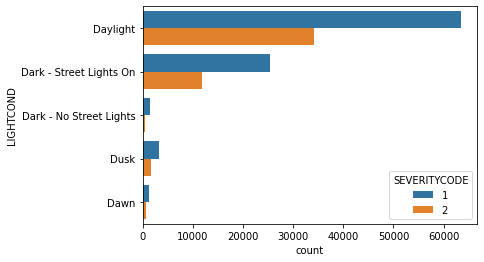

In [62]:
sns.countplot(y="LIGHTCOND", hue="SEVERITYCODE", data=colData)

In [64]:
from imblearn.under_sampling import RandomUnderSampler



In [67]:
X = colData[['X', 'Y', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT',
       'VEHCOUNT', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'SPEEDING', 'UNDERINFL', 'INATTENTIONIND']]
y = colData[['SEVERITYCODE']]

In [69]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [71]:
cd2 = X_resampled
cd2['severity'] = y_resampled

In [73]:
cd2['severity'].value_counts()

2    48923
1    48923
Name: severity, dtype: int64

<AxesSubplot:xlabel='count', ylabel='LIGHTCOND'>

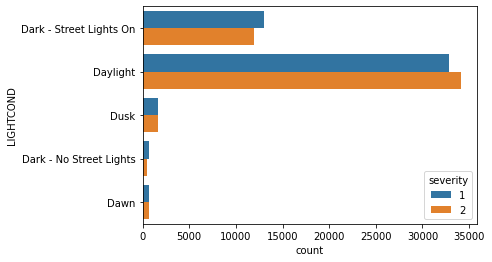

In [77]:
sns.countplot(y="LIGHTCOND", hue="severity", data=cd2)